In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [3]:
project_id = 'qwiklabs-gcp-02-04df2a73f7b5'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [4]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [5]:
# prompt: Convert the table ecommerce.customer_stats to a BigQuery DataFrames dataframe and show the top 10 records

df = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
df.head(10)

/usr/local/lib/python3.10/dist-packages/bigframes/pandas/__init__.py:398: UnknownLocationWarning: The location 'US' is set to an unknown value.
  options.bigquery.location = table.location


,user_id,days_since_last_order,count_orders,average_spend
0,50271,630,1,45.0
1,22784,587,8,55.9575
2,63781,777,3,30.316667
3,23355,579,1,20.0
4,81439,832,1,69.949997
5,43600,735,1,9.79
6,11186,657,1,197.5
7,44300,728,1,35.959999
8,38671,521,1,19.99
9,12229,753,1,40.0


In [7]:
# prompt: 1. Split df into test and training data for a K-means clustering algorithm store these as df_test_ and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model to BigQuery in a model called ecommerce.model_name using the to_gbq method.

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
model = KMeans(n_clusters=5)
model.fit(df_train)
model.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [8]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = model.predict(df)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
0,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.224800053794...",50271,630,1,45.0
1,2,"[{'CENTROID_ID': 2, 'DISTANCE': 5.926043153312...",22784,587,8,55.9575
2,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.585657854275...",63781,777,3,30.316667
3,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.161260152053...",23355,579,1,20.0
4,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.874181494580...",81439,832,1,69.949997
5,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.222483266044...",43600,735,1,9.79
6,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.280361074981...",11186,657,1,197.5
7,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.059108751811...",44300,728,1,35.959999
8,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.555627441487...",38671,521,1,19.99
9,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.999441160859...",12229,753,1,40.0


Exception ignored in: <generator object RowIterator._to_page_iterable at 0x7d05b038b220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/table.py", line 1789, in _to_page_iterable
    yield from result_pages
  File "/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/_pandas_helpers.py", line 907, in _download_table_bqstorage
    pool.shutdown(wait=True)
  File "/usr/lib/python3.10/concurrent/futures/thread.py", line 235, in shutdown
    t.join()
  File "/usr/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
KeyboardInterrupt: 


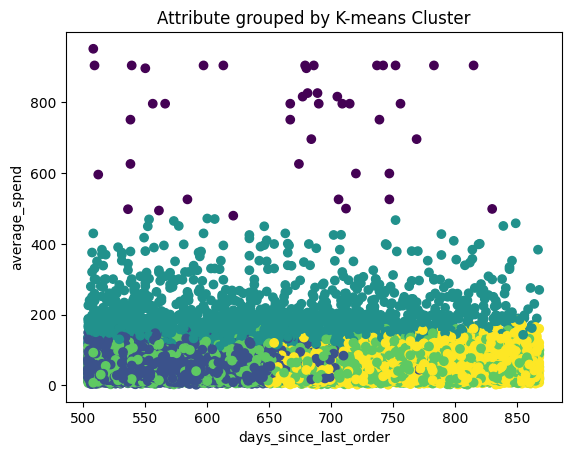

In [14]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. The chart should be titled "Attribute grouped by K-means cluster.

import matplotlib.pyplot as plt

plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'])
plt.xlabel("days_since_last_order")
plt.ylabel("average_spend")
plt.title("Attribute grouped by K-means Cluster")
plt.show()

In [15]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,753.19,1.06,658.29
1,cluster 2,48.36,2.01,579.19
2,cluster 3,191.76,1.31,640.11
3,cluster 4,46.69,1.59,672.12
4,cluster 5,48.33,1.39,773.16


In [16]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $753.19, count of orders per person 1.06, days since last order 658.29
cluster 2, average spend $48.36, count of orders per person 2.01, days since last order 579.19
cluster 3, average spend $191.76, count of orders per person 1.31, days since last order 640.11
cluster 4, average spend $46.69, count of orders per person 1.59, days since last order 672.12
cluster 5, average spend $48.33, count of orders per person 1.39, days since last order 773.16


In [17]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [25]:
# prompt: Use the Vertex AI language_models API to call the PaLM2 text-bison model and generate a marketing campaign using the variable prompt. Use the following model settings: max_output_tokens=1024, temperature=0.4

model = TextGenerationModel.from_pretrained("text-bison")
response = model.predict(prompt, max_output_tokens=1024, temperature=0.4)
print(response.text)

 **Cluster 1: The Big Spender**

* **Title:** The Loyal Luxury Seeker
* **Persona:** These customers are high-income individuals who have a taste for the finer things in life. They're willing to spend top dollar on products and services that they believe are worth it. They're also very loyal to brands that they love and trust.
* **Next marketing step:** Target these customers with exclusive offers and discounts. Make them feel like they're getting a special deal that's just for them. You can also try to upsell them on higher-priced products and services.

**Cluster 2: The Frequent Buyer**

* **Title:** The Value-Conscious Shopper
* **Persona:** These customers are always on the lookout for a good deal. They're not afraid to comparison shop and they're always looking for ways to save money. They're also more likely to be influenced by discounts and promotions.
* **Next marketing step:** Target these customers with flash sales and discounts. Offer them free shipping or other incentives t